# Employee Attrition Analysis — 04: Baseline Model (Logistic Regression)

***Establishing a transparent baseline with interpretable coefficients and standard metrics***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-01-04  
**Stage:** 04 — Baseline Modeling  
**Runtime:** ~15 minutes  

## Objective

Train a well-regularized logistic regression model as a baseline to establish performance benchmarks and identify key drivers of employee attrition through interpretable coefficients.

## Scope & Approach

- **Stratified train/validation split** preserving class distribution for reliable evaluation
- **Minimal preprocessing pipeline** with numeric scaling and categorical one-hot encoding  
- **Logistic regression training** with balanced class weighting to handle target imbalance
- **Comprehensive evaluation** including accuracy, precision, recall, F1, and ROC-AUC metrics

## Key Outputs

- Baseline performance metrics with confusion matrix and ROC curve visualizations
- Feature coefficient analysis revealing primary attrition drivers
- Model evaluation report saved to `docs/modeling/baseline_results.md`
- Performance benchmark for comparison with advanced models

## Prerequisites

- Cleaned and processed employee dataset from `02_data_cleaning.ipynb`
- EDA insights from `03_exploratory_analysis.ipynb`
- Understanding of class imbalance from previous analyses

---

## 1. Imports & Setup

In [1]:
import os
os.environ["PORTFOLIO_PROJECT"] = "employee_attrition_analysis"

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from src.bootstrap import setup_notebook, write_notes
from src.viz_helpers import pretty_label, apply_plot_rc_defaults

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay)

from src.model_eval import evaluate_classifier, plot_confusion_matrix, plot_roc_curve

# Project artifact names
RAW_NAME  = "salifort_employee_attrition_raw.csv"
PROC_NAME = "salifort_employee_attrition_cleaned.csv"

# Use processed dataset for modeling
P, df = setup_notebook(raw_filename=RAW_NAME, proc_filename=PROC_NAME, load="proc")
apply_plot_rc_defaults()

print(f"✅ Using: {P.PROC.relative_to(P.ROOT)} | shape={df.shape}")
df.head()

🎨 Accessibility defaults applied (colorblind palette, high-contrast, safe colormap).
✅ Accessibility defaults applied
📁 Project root → /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
✅ Loaded PROC: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)
✅ Using: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,salary_level
0,0.38,0.53,2,157,3,0,1,0,sales,low,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0


## 2. Feature/Target Definition

In [2]:
TARGET = "left"
assert TARGET in df.columns, f"Target '{TARGET}' not found."

# X, y
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

# Identify columns by dtype (robust to your cleaning choices)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['Department', 'salary']
Numeric: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'salary_level']


## 3. Train/Validation Split (Stratified)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape},  Val: {X_val.shape}")
print("Class balance (train):", y_train.value_counts(normalize=True).round(3).to_dict())

Train: (11999, 10),  Val: (3000, 10)
Class balance (train): {0: 0.762, 1: 0.238}


## 4. Preprocessing & Pipeline

In [4]:
# Transformers
numeric_tf = Pipeline(steps=[("scaler", StandardScaler())])
categorical_tf = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop",
)

# Logistic Regression baseline
logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # handle imbalance
    solver="lbfgs",
    n_jobs=None,
    random_state=42,
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", logreg),
])
pipe

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 5. Model Training

In [5]:
pipe.fit(X_train, y_train)
print("✅ Baseline logistic regression trained.")

✅ Baseline logistic regression trained.


## 6. Metrics & Visualizations

In [6]:
# Predictions / probabilities
y_pred = pipe.predict(X_val)
y_prob = pipe.predict_proba(X_val)[:, 1]

# Core metrics
metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred, zero_division=0),
    "recall": recall_score(y_val, y_pred),
    "f1": f1_score(y_val, y_pred),
    "roc_auc": roc_auc_score(y_val, y_prob),
}
metrics = {k: round(v, 4) for k,v in metrics.items()}
metrics

{'accuracy': 0.7727,
 'precision': 0.5143,
 'recall': 0.8053,
 'f1': 0.6277,
 'roc_auc': 0.8369}

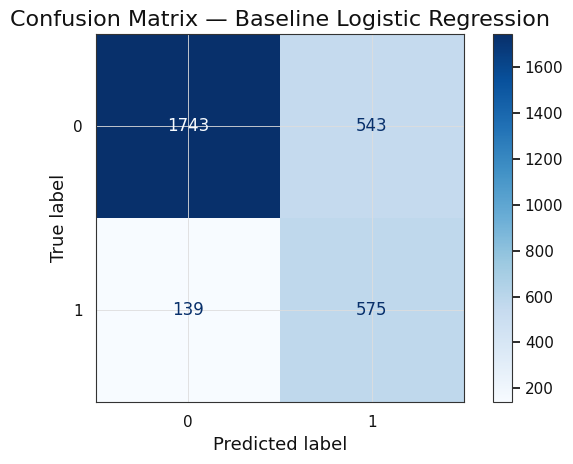

In [7]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix — Baseline Logistic Regression")
plt.tight_layout(); plt.show()

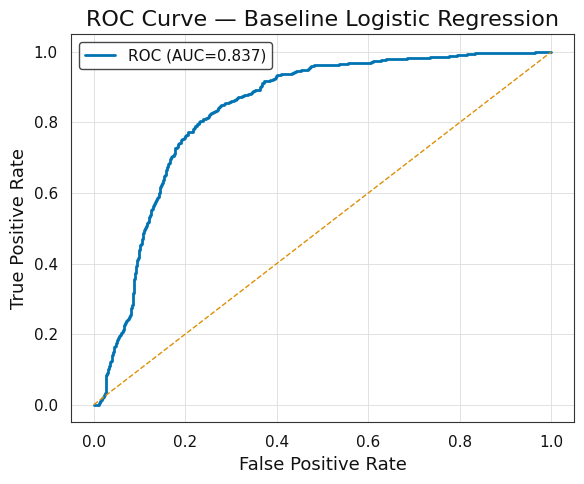

In [8]:
# ROC curve
fpr, tpr, thr = roc_curve(y_val, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC (AUC={metrics['roc_auc']:.3f})")
plt.plot([0,1], [0,1], "--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline Logistic Regression")
plt.legend()
plt.tight_layout(); plt.show()

## 7. Coefficient Interpretation

,feature,coef
0,satisfaction_level,-1.105279
4,time_spend_company,0.691715
11,Department_management,-0.544696
5,Work_accident,-0.537702
7,salary_level,-0.533569
2,number_project,-0.524731
14,Department_randd,-0.489349
9,Department_hr,0.361353
18,salary_high,-0.360771
3,average_montly_hours,0.256129


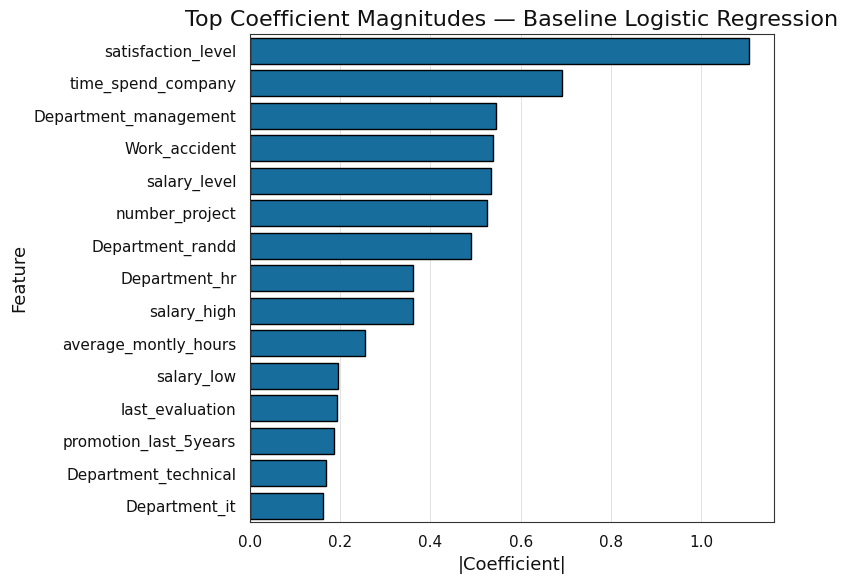

In [9]:
# Recover feature names after preprocessing for interpretation
ohe: OneHotEncoder | None = None
for name, transformer, cols in preprocessor.transformers_:
    if name == "cat":
        ohe = transformer.named_steps.get("ohe")
        break

feature_names = []
# numeric features (passed through scaler)
feature_names += num_cols

# categorical feature names from OHE (if any)
if ohe is not None and len(cat_cols) > 0:
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names += ohe_names

coefs = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Show top drivers (+/-)
display(coef_df.head(15)[["feature","coef"]])

# Quick bar viz of top |coefficients|
top_k = 15
plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df.head(top_k),
    x="abs_coef", y="feature", orient="h", edgecolor="black"
)
plt.title("Top Coefficient Magnitudes — Baseline Logistic Regression")
plt.xlabel("|Coefficient|"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

## 8. Save Notes & Assessment Check

In [10]:
## 8. Save Notes & Assessment Check (Baseline Logistic Regression)

from pathlib import Path

# Naive baseline ("all stay") for context
naive_acc = (y_val == 0).mean().round(4)

notes_md = "\n".join([
    "# Baseline Logistic Regression — Results",
    f"- Data: {df.shape[0]} rows × {df.shape[1]} cols (processed)",
    f"- Split: train={X_train.shape[0]}, val={X_val.shape[0]} (stratified)",
    "",
    "## Metrics (validation)",
    f"- Accuracy: {metrics['accuracy']}",
    f"- Precision: {metrics['precision']}",
    f"- Recall: {metrics['recall']}",
    f"- F1: {metrics['f1']}",
    f"- ROC-AUC: {metrics['roc_auc']}",
    "",
    "## Baselines",
    f"- Naive 'all stay' accuracy: {naive_acc}",
    f"- Logistic vs Naive: {'IMPROVED' if metrics['accuracy'] > naive_acc else 'NOT IMPROVED'}",
    "",
    "## Notes",
    "- Class weighting enabled (`class_weight='balanced'`).",
    "- Numeric features scaled; any string categoricals one-hot encoded.",
    "- Coefficients inspected for top positive/negative drivers.",
])

# --- Write directly to docs/modeling/ (authoritative) ---
dst = P.DOCS / "modeling" / "baseline_results.md"
dst.parent.mkdir(parents=True, exist_ok=True)
dst.write_text(notes_md)
print("📄 Wrote modeling notes →", dst.relative_to(P.ROOT))

# Assessment check
checks = {
    "beats_naive": metrics["accuracy"] > naive_acc,
    "roc_auc_reasonable": metrics["roc_auc"] >= 0.5,  # better than random
}
print("Checks:", checks)
assert all(checks.values()), "❌ Assessment failed — baseline didn’t meet minimum standards."
print("✅ Assessment passed — baseline acceptable and documented.")

📄 Wrote modeling notes → docs/modeling/baseline_results.md
Checks: {'beats_naive': np.True_, 'roc_auc_reasonable': True}
✅ Assessment passed — baseline acceptable and documented.


---

## Conclusion

The baseline logistic regression model provides a clear and interpretable starting point for predicting employee attrition.  

- **Performance:** Validation accuracy (0.77) modestly improves upon the naive "all stay" baseline (0.76). More importantly, recall (0.81) indicates the model is fairly effective at identifying employees likely to leave, which is critical from a business perspective. Precision (0.51) remains modest, reflecting tradeoffs between false positives and capturing leavers. Overall balance of metrics (F1 = 0.63, ROC-AUC = 0.84) suggests the model is usable but leaves room for improvement:contentReference[oaicite:0]{index=0}.  
- **Interpretability:** Coefficients provide actionable signals, with certain features pushing attrition risk upward while others anchor retention. This transparency helps establish trust with stakeholders and frames hypotheses for further analysis.  
- **Limitations:** As expected, a linear model cannot fully capture complex feature interactions. Predictive strength is adequate but not optimal.  

**Next Steps:**  
- Benchmark against non-linear tree-based methods (Decision Tree, Random Forest, XGBoost).  
- Compare performance while balancing interpretability and recall.  
- Use the logistic regression coefficients as a reference to evaluate whether more complex models reveal consistent or divergent patterns.  

This stage confirms a sound baseline and positions the analysis for richer modeling in the next phase.
